# Chemprot minimal dataset

This removes duplicated abstracts

In [1]:
bucket="aegovan-data"

train_data = f"s3://{bucket}/chemprot/chemprot_abstract_train.json"
test_data = f"s3://{bucket}/chemprot/chemprot_abstract_test.json"
val_data = f"s3://{bucket}/chemprot/chemprot_abstract_val.json"



output_data = f"s3://{bucket}/chemprot_minimal"



In [2]:

from datetime import datetime

datefmt = datetime.now().strftime("%Y%m%d%H%M")

output_data = f"{output_data}/{datefmt}"

In [3]:
import pandas as pd
import sagemaker, io

In [4]:
df = pd.read_json( io.StringIO(sagemaker.s3.S3Downloader.read_file(train_data)))
df.sample(n=3)

,abstract_id,abstract,participant1_id,participant1,participant2_id,participant2,annotations,relationship_type,relationship_group,is_eval,label
365,10839989,Contrasting effects of N5-substituted tetrahyd...,T44,"{'abstract_id': '10839989', 'id': 'T44', 'enti...",T64,"{'abstract_id': '10839989', 'id': 'T64', 'enti...","[{'abstract_id': '10839989', 'id': 'T1', 'enti...",REGULATOR,CPR:2,N,NEGATIVE
1524,15114505,In vitro inhibition of diacylglycerol acyltran...,T11,"{'abstract_id': '15114505', 'id': 'T11', 'enti...",T25,"{'abstract_id': '15114505', 'id': 'T25', 'enti...","[{'abstract_id': '15114505', 'id': 'T1', 'enti...",INHIBITOR,CPR:4,Y,CPR:4
2332,17015640,"Licofelone, a balanced inhibitor of cyclooxyge...",T17,"{'abstract_id': '17015640', 'id': 'T17', 'enti...",T33,"{'abstract_id': '17015640', 'id': 'T33', 'enti...","[{'abstract_id': '17015640', 'id': 'T1', 'enti...",INHIBITOR,CPR:4,Y,CPR:4


<AxesSubplot:ylabel='Frequency'>

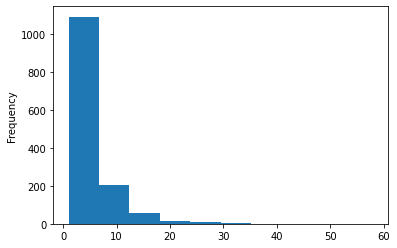

In [5]:
df.groupby(["abstract_id", "label"]).size().plot.hist()

In [6]:
df.shape

(6437, 11)

In [7]:
df.groupby(["abstract_id", "label"]).size().describe()

count    1382.000000
mean        4.657742
std         4.838381
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        58.000000
dtype: float64

In [8]:
pd.DataFrame({'Percentage': df.groupby([ 'label']).size() * 100 / len(df)})

,Percentage
label,
CPR:3,12.070840
CPR:4,35.109523
CPR:5,2.687587
CPR:6,3.650769
CPR:9,11.294081
NEGATIVE,35.187199


In [9]:
df.groupby(["label"]).size()

label
CPR:3        777
CPR:4       2260
CPR:5        173
CPR:6        235
CPR:9        727
NEGATIVE    2265
dtype: int64

In [10]:
df = df.drop_duplicates(subset=['abstract_id', 'label'])

In [11]:
df.groupby(["abstract_id", "label"]).size().describe()

count    1382.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64

In [12]:
df.groupby(["label"]).size()

label
CPR:3       210
CPR:4       413
CPR:5        56
CPR:6        76
CPR:9       148
NEGATIVE    479
dtype: int64

In [13]:
pd.DataFrame({'Percentage': df.groupby([ 'label']).size() * 100 / len(df)})

,Percentage
label,
CPR:3,15.195369
CPR:4,29.884226
CPR:5,4.052098
CPR:6,5.499276
CPR:9,10.709117
NEGATIVE,34.659913


In [14]:
df.shape

(1382, 11)

In [15]:
def upload_to_s3(df, s3_uri):
    json_data = io.StringIO() 
    df.to_json( json_data )


    sagemaker.s3.S3Uploader.upload_string_as_file_body(json_data.getvalue(), s3_uri)

In [16]:
import numpy as np

def get_stats(df, pos_label):
    stats ={}
    
    # Positive samples
    df_positive = df.query(f"label == '{pos_label}'")
    df_positive_unique = df_positive.drop_duplicates('abstract_id')
    stats["UniquePositives"] = len(df_positive_unique)
    stats["AllPositives"] = len(df_positive)
    stats["AffablePositives"] = len(df_positive) - len(df_positive_unique)
    stats["AffablePositiveRate"] = stats["AffablePositives"]/len(df_positive)



    stats["UniquePositiveSampleRate"] = stats["UniquePositives"]/(len(df))
    stats["PositiveSampleRate"] = stats["AllPositives"]/(len(df))
    
    
    # Negative samples
    df_negative = df.query(f"label != '{pos_label}'")
    df_negative_unique = df_negative.drop_duplicates('abstract_id')


    stats["UniqueNegatives"] = len(df_negative_unique)
    stats["AllNegatives"] = len(df_negative)
    stats["AffableNegatives"] = len(df_negative) - len(df_negative_unique)
    stats["AffableNegativeRate"] = stats["AffableNegatives"]/stats["AllNegatives"] 


    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"label == '{pos_label}'")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries = df[~abstracts_id_with_positive]
    df_negative_non_adverseries_unique =df_negative_non_adverseries.drop_duplicates('abstract_id')
    stats["UniqueNonAdversarialNegatives"] = len(df_negative_non_adverseries_unique)
    stats["AllNonAdversarialNegatives"] = len(df_negative_non_adverseries)

    # Adversarial  Negative: Unique negative samples with matching positive samples
    df_negative_adverseries = df[abstracts_id_with_positive].query(f"label != '{pos_label}'")
    df_negative_adverseries_unique = df_negative_adverseries.drop_duplicates('abstract_id')
    stats["UniqueAdversarialNegatives"] = len(df_negative_adverseries_unique)
    stats["AllAdversarialNegatives"] = len(df_negative_adverseries)
    
    # TODO: Check if unique positive is appropriate
    stats["AdversarialRate"] = stats["AllAdversarialNegatives"]/len(df_positive)
    stats["UniqueAdversarialRate"] = stats["UniqueAdversarialNegatives"]/len(df_positive)


    stats["TotalSize"] = len(df)
    stats["UniqueAbstracts"] = df["abstract"].nunique()


    return stats






In [17]:
upload_to_s3(df, f"{output_data}/chemprot_abstract_train.json")

In [18]:
output_data

's3://aegovan-data/chemprot_minimal/202212161734'